# Spike count trials regression

### Table of contents

1. [**Synthetic heteroscedastic count data**](#data)
2. [**Model recovery**](#recover)
3. [**Fitting the UCM**](#fit)
4. [**Evaluating the UCM**](#eval)


In [1]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")


import neuroprob as nprb
from neuroprob import utils
from neuroprob.likelihoods.discrete import gen_NB


dev = nprb.inference.get_device()  # PyTorch device, gpu 0 by default if available

PyTorch version: 1.13.0+cu117
Using device: cuda:0


<a id="synthetic"></a>
## 1. Synthetic heteroscedastic count data

In [2]:
def HDC_bumps(theta, A, invbeta, b, theta_0):
    """
    parameters have shape (neurons,)
    :return:
        rates of shape (..., neurons, eval_pts)
    """
    return A[:, None] * np.exp(
        (np.cos(theta[..., None, :] - theta_0[:, None]) - 1) / invbeta[:, None]) + b[:, None]


In [3]:
trial_len = 1000
trials = 100
rng = np.random.default_rng(123)  # seed RNG

# angular stimulus presentations
angle_t = np.empty(timesamples)

for tr in range(trials):
    

In [4]:
tbin = 0.05
neurons = 50

# von Mises fields
p_c = rng.normal(size=(neurons,))**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*rng.normal(size=(neurons,)))
p_b = 0.2*rng.normal(size=(neurons,))**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

_angle_0 = rng.permutation(p_z)
_beta = (0.2 * rng.normal(size=(neurons,)))**2 + 0.01
_rate_0 = rng.uniform(size=(neurons,)) * 30.0
_b = rng.uniform(size=(neurons,)) * 1.

# rate tuning curve
vm_rate = lambda x: HDC_bumps(x, p_a, p_b, p_c, p_z)

# dispersion tuning curve
vm_disp = lambda x: HDC_bumps(x, _rate_0, 1e6 * np.ones_like(1./_beta), _b, _angle_0)

In [5]:
steps = 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)

rate = vm_rate(covariates)
r = vm_disp(covariates)

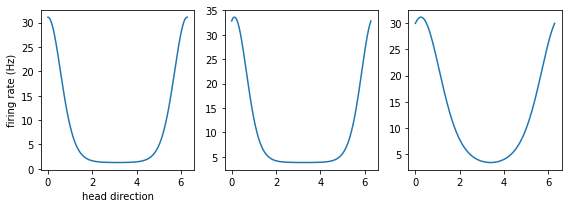

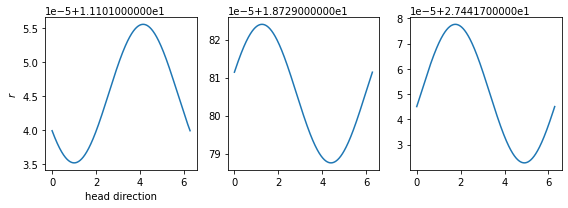

In [6]:
fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, rate[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')
    
fig.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, r[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$r$')
    
fig.tight_layout()
plt.show()

In [7]:
# generate data
rate_t = vm_rate(hd_t)
r_t = vm_disp(hd_t)

syn_train = gen_NB(rng, rate_t*tbin, r_t)

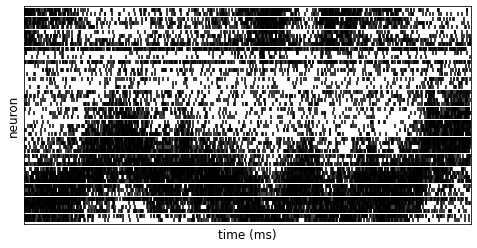

In [8]:
T = 1000

fig, ax = plt.subplots(figsize=(8,4))
utils.plots.raster_plot((fig, ax), syn_train[:, :T], T, tbin*1000, neurons, markersize=10)
utils.plots.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.show()